In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

## Inference data run

In [3]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|██████████| 473/473 [00:09<00:00, 51.73it/s]


Processed 473 samples to data/inference.csv


x_mean     x_std     x_max     x_min    x_range    x_skew  x_kurtosis  \
0    0.058921  0.141937  0.263645 -0.227241   0.490886 -0.411727   -1.269705   
1    0.106114  0.269372  1.778952 -0.216834   1.995787  3.211183   15.644389   
2    0.789526  2.145882  9.063698 -5.985732  15.049430  0.780326    3.492323   
3    0.608177  1.767987  7.425284 -5.526085  12.951369  0.051386    2.937480   
4   -1.194933  1.703552  5.421388 -5.423952  10.845341  1.637340    4.764184   
..        ...       ...       ...       ...        ...       ...         ...   
468 -1.636018  1.836926  6.591974 -9.584012  16.175985  0.312256    7.618219   
469  0.060071  0.144546  0.310245 -0.195478   0.505723 -0.337960   -1.312457   
470  0.558987  1.950833  8.567100 -4.938564  13.505664  0.908525    4.674787   
471  0.102132  0.273789  1.820321 -0.219719   2.040041  3.268718   16.336809   
472 -0.587418  2.236118  5.314518 -9.728679  15.043198 -0.744848    2.708572   

     x_n_peaks    x_energy    y_mean  ...  temperature  humidity  altitude  \
0           17    2.361775  0.016296  ...           29        21       383   
1            1    8.382128  0.056256  ...           15        58       163   
2           11  522.816335  0.819377  ...           32        55       838   
3           15  349.565584  1.388228  ...           24        71       166   
4            5  432.995344 -0.195628  ...           27        52       720   
..         ...         ...       ...  ...          ...       ...       ...   
468          3  605.085057  1.075774  ...           24        75       720   
469         13    2.450196  0.015352  ...           17        78       945   
470          8  411.821559 -0.130941  ...           30        34       574   
471          1    8.539161  0.016576  ...           26        23        55   
472          7  534.528186  0.904789  ...           29        32       713   

     session_id  firmware_version  calibration_status  battery_level  \
0       S910846            v1.2.4             pending             97   
1       S745147            v1.3.0             pending             60   
2       S815741            v1.3.0                  ok             39   
3       S192238            v1.2.3                  ok             46   
4       S146695            v1.2.3              recent             36   
..          ...               ...                 ...            ...   
468     S259109            v1.2.3                  ok             76   
469     S852576            v1.2.4                  ok             91   
470     S639486            v1.2.3              recent             95   
471     S935107            v1.2.4                  ok             76   
472     S526886            v1.2.3              recent             32   

     gps_accuracy  network_type  device_model  
0        5.613430            5g       model_b  
1        1.196678            5g       model_b  
2        3.882185          wifi       model_b  
3        3.886005          wifi       model_b  
4        7.753421            4g       model_a  
..            ...           ...           ...  
468      3.351859            5g       model_b  
469      6.921099            5g       model_b  
470      8.046290            4g       model_a  
471      7.027533            4g       model_a  
472      4.625958            5g       model_c  

[473 rows x 60 columns]

In [4]:
import pandas as pd
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

In [5]:
import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

## Evaluation of the model results with the inference data

In [6]:
preds_series = pd.Series(preds)
df_inf = pd.concat([df_inf, preds_series], axis=1).rename(columns={0: 'inf_preds'})
df_inf = pd.merge(df_inf, labels, on='sample_id')

In [7]:
from sklearn import metrics
inf_accuracy = metrics.accuracy_score(df_inf['label'], df_inf['inf_preds'])
inf_accuracy

0.6448202959830867

In [8]:
inf_precision = metrics.precision_score(df_inf['label'], df_inf['inf_preds'], pos_label="collision")
inf_precision

0.5885416666666666

In [9]:
inf_recall = metrics.recall_score(df_inf['label'], df_inf['inf_preds'], pos_label="collision")
inf_recall

0.9576271186440678

In [10]:
inf_f1 = metrics.f1_score(df_inf['label'], df_inf['inf_preds'], pos_label="collision")
inf_f1

0.7290322580645161

## Evaluation of the model results with the test data

In [11]:
df_test = pd.read_csv("data/test.csv")
test_labels = df_test[['sample_id', 'label']]
df_test = df_test.drop('label', axis=1)

In [12]:
test_preds = model.predict(df_test)
test_probs = model.predict_proba(df_test)

In [13]:
test_preds_series = pd.Series(test_preds)
df_test = pd.concat([df_test, test_preds_series], axis=1).rename(columns={0: 'test_preds'})
df_test = pd.merge(test_labels, df_test, on='sample_id')

In [14]:
test_accuracy = metrics.accuracy_score(df_test['label'], df_test['test_preds'])
test_accuracy

0.945

In [15]:
test_precision = metrics.precision_score(df_test['label'], df_test['test_preds'], pos_label="collision")
test_precision

1.0

In [16]:
test_recall = metrics.recall_score(df_test['label'], df_test['test_preds'], pos_label="collision")
test_recall

0.89

In [17]:
test_f1 = metrics.f1_score(df_test['label'], df_test['test_preds'], pos_label="collision")
test_f1

0.9417989417989417

## Exploratory data analysis for test and inference data

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sample_id            200 non-null    object 
 1   label                200 non-null    object 
 2   x_mean               200 non-null    float64
 3   x_std                200 non-null    float64
 4   x_max                200 non-null    float64
 5   x_min                200 non-null    float64
 6   x_range              200 non-null    float64
 7   x_skew               200 non-null    float64
 8   x_kurtosis           200 non-null    float64
 9   x_n_peaks            200 non-null    int64  
 10  x_energy             200 non-null    float64
 11  y_mean               200 non-null    float64
 12  y_std                200 non-null    float64
 13  y_max                200 non-null    float64
 14  y_min                200 non-null    float64
 15  y_range              200 non-null    flo

In [19]:
df_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x_mean               473 non-null    float64
 1   x_std                473 non-null    float64
 2   x_max                473 non-null    float64
 3   x_min                473 non-null    float64
 4   x_range              473 non-null    float64
 5   x_skew               473 non-null    float64
 6   x_kurtosis           473 non-null    float64
 7   x_n_peaks            473 non-null    int64  
 8   x_energy             473 non-null    float64
 9   y_mean               473 non-null    float64
 10  y_std                473 non-null    float64
 11  y_max                473 non-null    float64
 12  y_min                473 non-null    float64
 13  y_range              473 non-null    float64
 14  y_skew               473 non-null    float64
 15  y_kurtosis           473 non-null    flo

In [20]:
df_test.describe()

x_mean       x_std       x_max       x_min     x_range      x_skew  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.072357    0.175786    0.664455   -0.220048    0.884504    0.559799   
std      0.017860    0.055861    0.658683    0.016384    0.661643    1.596366   
min      0.054032    0.135434    0.243381   -0.263373    0.449476   -0.495403   
25%      0.060971    0.142917    0.272585   -0.230493    0.489645   -0.391401   
50%      0.063618    0.145604    0.287526   -0.219011    0.507897   -0.352403   
75%      0.087493    0.213218    1.222295   -0.210534    1.434266    1.926341   
max      0.115545    0.328847    2.217390   -0.183492    2.449410    4.162503   

       x_kurtosis   x_n_peaks    x_energy      y_mean  ...   z_fft_max  \
count  200.000000  200.000000  200.000000  200.000000  ...  200.000000   
mean     3.202769   12.545000    3.955851    0.020692  ...  984.017783   
std      7.764374    5.871144    2.676421    0.010946  ...    0.883487   
min     -1.426503    1.000000    2.230482    0.007860  ...  981.667163   
25%     -1.305365   10.000000    2.435282    0.014331  ...  983.985994   
50%     -1.243227   15.000000    2.503460    0.016582  ...  984.358216   
75%      8.440557   16.000000    5.378324    0.020339  ...  984.569317   
max     23.314467   21.000000   12.149115    0.057828  ...  985.249245   

       z_fft_mean     xy_corr     xz_corr     yz_corr  temperature  \
count  200.000000  200.000000  200.000000  200.000000   200.000000   
mean    20.105874    0.214421    0.112124   -0.378091    22.455000   
std      0.240592    0.161617    0.272536    0.196146     7.562668   
min     19.944433   -0.203699   -0.812065   -0.799249    10.000000   
25%     19.979297    0.166963    0.122438   -0.504016    16.000000   
50%     19.993094    0.201374    0.200910   -0.432126    23.000000   
75%     20.019486    0.230380    0.243362   -0.296286    29.000000   
max     20.726103    0.733757    0.399811    0.227491    34.000000   

         humidity    altitude  battery_level  gps_accuracy  
count  200.000000  200.000000     200.000000    200.000000  
mean    49.105000  510.165000      60.195000      5.445168  
std     16.787887  275.843208      23.187611      2.586010  
min     20.000000   12.000000      20.000000      1.001352  
25%     35.000000  263.750000      39.000000      3.153606  
50%     47.500000  536.000000      60.000000      5.815119  
75%     64.000000  741.250000      79.250000      7.569848  
max     79.000000  987.000000      99.000000      9.926096  

[8 rows x 46 columns]

In [21]:
df_inf.describe()

x_mean       x_std       x_max       x_min     x_range      x_skew  \
count  473.000000  473.000000  473.000000  473.000000  473.000000  473.000000   
mean     0.334443    1.473291    5.338022   -4.531746    9.869767    0.156174   
std      0.863758    1.005728    3.972661    3.743591    7.180939    1.029517   
min     -2.379533    0.137185    0.243729  -15.242395    0.458411   -2.554885   
25%      0.058227    0.148782    0.308158   -7.434143    0.543138   -0.393114   
50%      0.071445    1.851954    6.047633   -4.759934   12.216376   -0.132100   
75%      0.790174    2.261465    8.347333   -0.228347   15.151209    0.404405   
max      3.306673    3.362332   20.341059   -0.183050   28.703527    3.816361   

       x_kurtosis   x_n_peaks     x_energy      y_mean  ...    z_fft_max  \
count  473.000000  473.000000   473.000000  473.000000  ...   473.000000   
mean     2.964973   12.953488   403.629173    0.482968  ...  1005.767172   
std      4.485354    6.808982   352.366176    0.982501  ...   103.778212   
min     -1.419090    1.000000     2.290863   -2.157744  ...   698.956952   
25%     -1.136078    8.000000     2.616417    0.014012  ...   972.747356   
50%      2.229525   13.000000   435.367857    0.044132  ...   984.551334   
75%      3.920972   17.000000   632.524802    1.125318  ...  1054.251305   
max     26.845024   35.000000  1583.362159    3.988793  ...  1423.972943   

       z_fft_mean     xy_corr     xz_corr     yz_corr  temperature  \
count  473.000000  473.000000  473.000000  473.000000   473.000000   
mean    25.337286    0.063771    0.041695   -0.155095    21.852008   
std      4.369337    0.182792    0.200682    0.229375     7.305622   
min     19.932253   -0.423129   -0.819585   -0.831291    10.000000   
25%     20.028244   -0.069651   -0.073242   -0.340279    16.000000   
50%     26.050121    0.074067    0.053484   -0.109783    22.000000   
75%     28.912243    0.196018    0.191947    0.006825    28.000000   
max     36.189323    0.685087    0.402405    0.359731    34.000000   

         humidity    altitude  battery_level  gps_accuracy  
count  473.000000  473.000000     473.000000    473.000000  
mean    50.183932  495.238901      59.902748      5.507064  
std     17.015758  280.088576      23.062623      2.585258  
min     20.000000    0.000000      20.000000      1.002815  
25%     35.000000  266.000000      40.000000      3.324777  
50%     51.000000  502.000000      59.000000      5.659139  
75%     64.000000  725.000000      80.000000      7.660658  
max     79.000000  996.000000      99.000000      9.982535  

[8 rows x 46 columns]

In [22]:
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

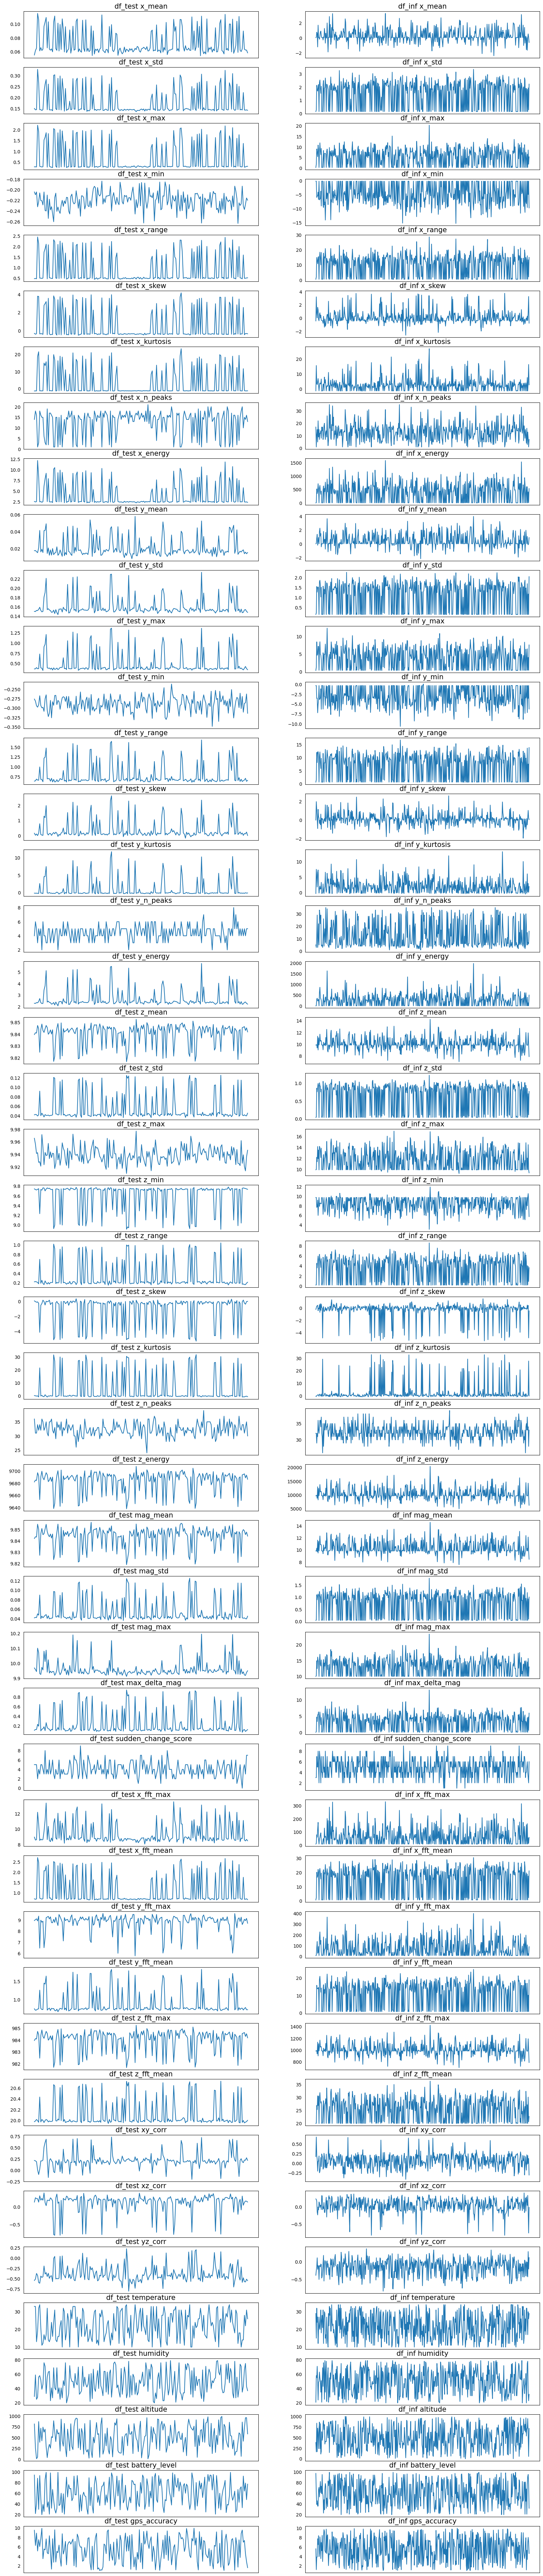

In [23]:
df_inf_numeric = df_inf.select_dtypes(include=['number'])
column_names = list(df_inf_numeric.columns)

datasets = [df_test, df_inf]
titles = ['df_test', 'df_inf']

fig, axs = plt.subplots(len(column_names), 2, figsize=(20,100))
for i in range(len(column_names)):
    for j in range(2):
        axs[i, j].plot(datasets[j][column_names[i]])
        axs[i, j].set_title(f'{titles[j]} {column_names[i]}', fontsize=15)
        axs[i, j].tick_params(bottom=False, top=False, left=False, right=False)
        axs[i, j].set_xticklabels([])
plt.show()

In [24]:
df_test.describe(include=["object"])

sample_id   label sensor_source  \
count                                    200     200           200   
unique                                   200       2             1   
top     dbf5e5c1-34bb-475b-aaee-750d1fd6cf91  normal        camera   
freq                                       1     100           200   

                         timestamp weather driver_id vehicle_type speed_bin  \
count                          200     200       200          200       200   
unique                         200       3        90            3         3   
top     2025-05-25 14:34:55.659958    rain     D1024        truck      fast   
freq                             1      70         6           72        74   

       road_type time_of_day session_id firmware_version calibration_status  \
count        200         200        200              200                200   
unique         3           4        200                3                  3   
top      highway   afternoon    S186189           v1.2.4             recent   
freq          74          56          1               79                 72   

       network_type device_model test_preds  
count           200          200        200  
unique            3            3          2  
top              4g      model_a     normal  
freq             68           71        111

In [25]:
df_inf.describe(include=["object"])

sample_id sensor_source  \
count                                    473           473   
unique                                   473             2   
top     0143cf13-fd51-44fd-8dd4-c2c92f5db7bd         phone   
freq                                       1           309   

                         timestamp weather driver_id vehicle_type speed_bin  \
count                          473     473       473          473       473   
unique                         473       3        99            3         3   
top     2025-05-25 14:34:56.480223    rain     D1077        sedan      slow   
freq                             1     172        12          167       166   

       road_type time_of_day session_id firmware_version calibration_status  \
count        473         473        473              473                473   
unique         3           4        473                3                  3   
top        urban   afternoon    S910846           v1.2.4            pending   
freq         167         126          1              166                171   

       network_type device_model  inf_preds   label  
count           473          473        473     473  
unique            3            3          2       2  
top              5g      model_a  collision  normal  
freq            173          162        384     237

In [26]:
df_inf.groupby('sensor_source').size().reset_index(name='count')

sensor_source  count
0        camera    164
1         phone    309

In [27]:
df_test.groupby('sensor_source').size().reset_index(name='count')

sensor_source  count
0        camera    200

In [28]:
import numpy as np
df_inf['correct_prediction'] = np.where(df_inf['label'] == df_inf['inf_preds'], True, False)
df_test['correct_prediction'] = np.where(df_test['label'] == df_test['test_preds'], True, False)

df_inf_good_predictions = df_inf[df_inf['correct_prediction'] == True]
df_inf_bad_predictions = df_inf[df_inf['correct_prediction'] == False]

df_test_good_predictions = df_test[df_test['correct_prediction'] == True]
df_test_bad_predictions = df_test[df_test['correct_prediction'] == False]

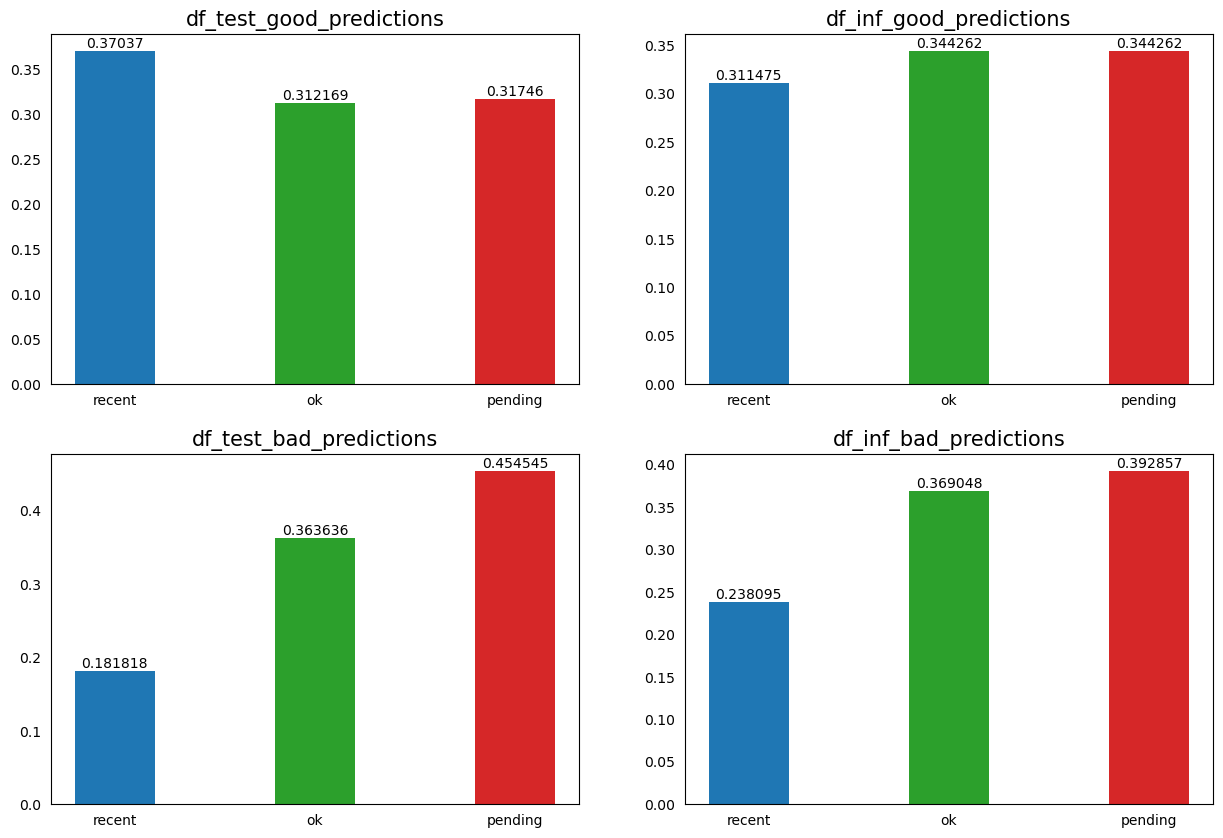

In [41]:
datasets = [df_test_good_predictions, df_inf_good_predictions, df_test_bad_predictions, df_inf_bad_predictions]
custom_order = ['recent', 'ok', 'pending']
new_datasets = []
for dataset in datasets:
    new_df = dataset['calibration_status'].value_counts(normalize=True).reset_index()
    new_df['calibration_status'] = pd.Categorical(new_df['calibration_status'], categories=custom_order, ordered=True)
    new_df_sorted = new_df.sort_values('calibration_status')
    new_datasets.append(new_df_sorted)

titles = ['df_test_good_predictions', 'df_inf_good_predictions', 'df_test_bad_predictions', 'df_inf_bad_predictions']
bar_colors = ['tab:blue', 'tab:green', 'tab:red']

fig, axs = plt.subplots(2, 2, figsize=(15,10))
ind = 0
for i in range(2):
    for j in range(2):
        bars = axs[i, j].bar(new_datasets[ind]['calibration_status'], new_datasets[ind]['proportion'], color=bar_colors, width = 0.4)
        axs[i, j].bar_label(bars)
        axs[i, j].set_title(titles[ind], fontsize=15)
        axs[i, j].tick_params(bottom=False, top=False, left=False, right=False)
        ind += 1
plt.show()

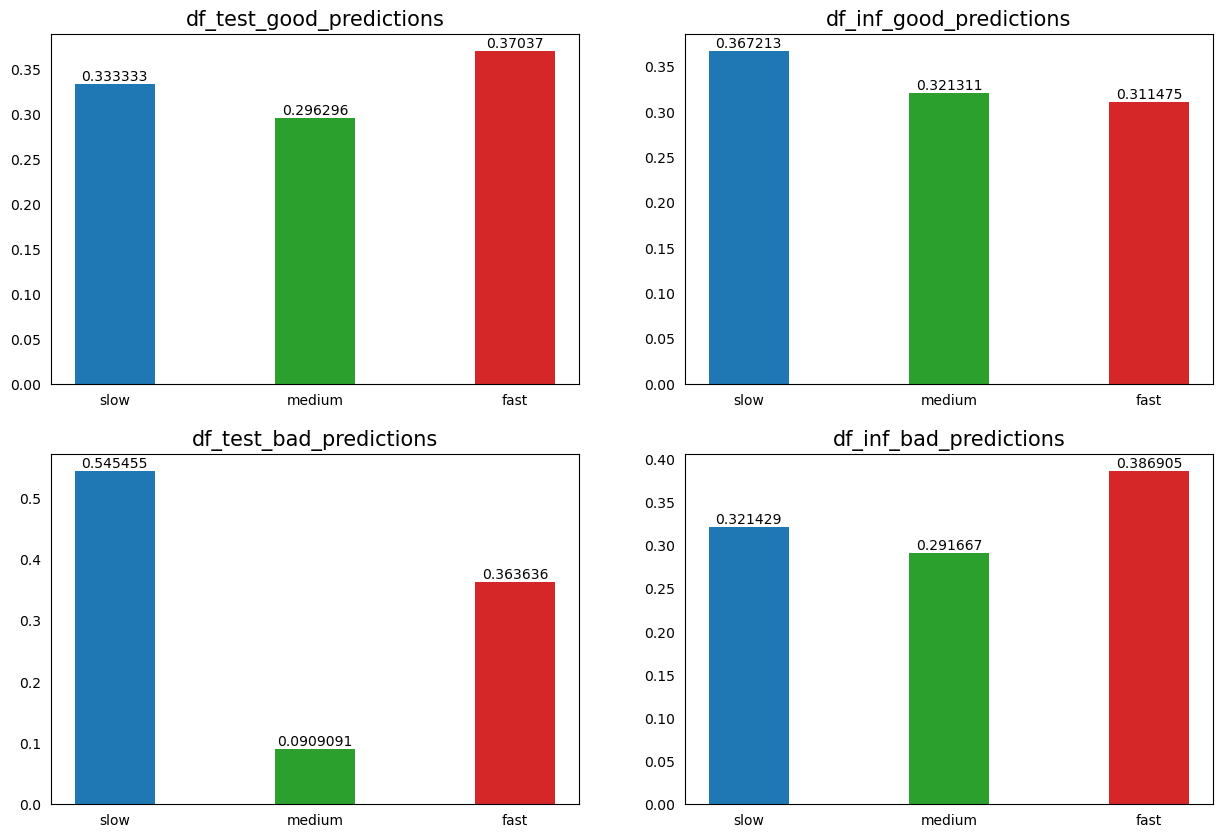

In [57]:
custom_order = ['slow', 'medium', 'fast']
new_datasets = []
for dataset in datasets:
    new_df = dataset['speed_bin'].value_counts(normalize=True).reset_index()
    new_df['speed_bin'] = pd.Categorical(new_df['speed_bin'], categories=custom_order, ordered=True)
    new_df_sorted = new_df.sort_values('speed_bin')
    new_datasets.append(new_df_sorted)

fig, axs = plt.subplots(2, 2, figsize=(15,10))
ind = 0
for i in range(2):
    for j in range(2):
        bars = axs[i, j].bar(new_datasets[ind]['speed_bin'], new_datasets[ind]['proportion'], color=bar_colors, width = 0.4)
        axs[i, j].bar_label(bars)
        axs[i, j].set_title(titles[ind], fontsize=15)
        axs[i, j].tick_params(bottom=False, top=False, left=False, right=False)
        ind += 1
plt.show()

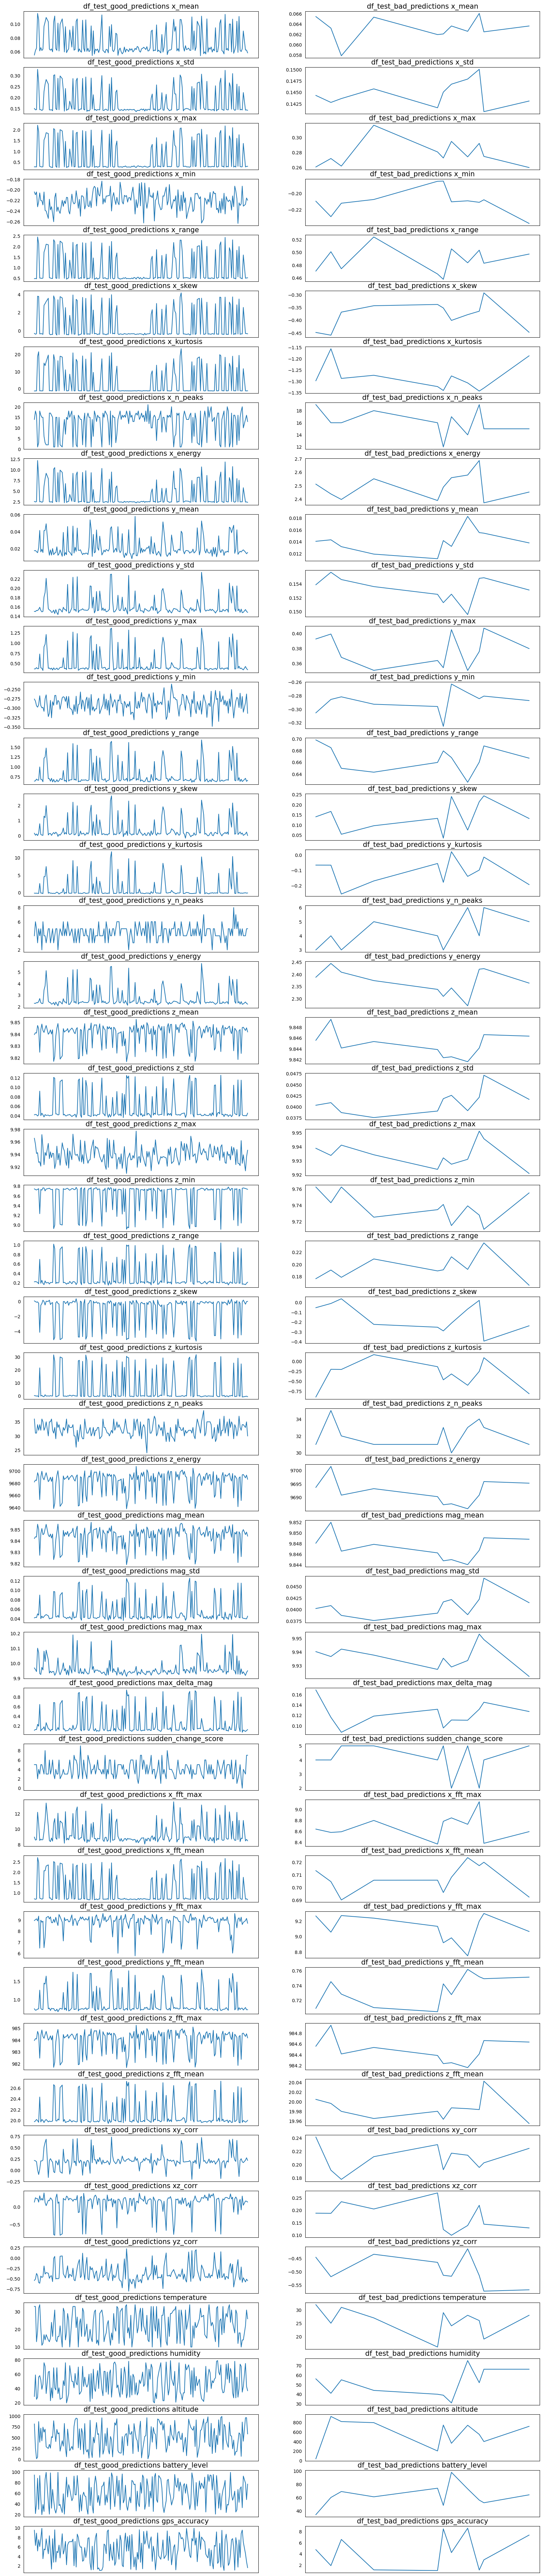

In [31]:
datasets = [df_test_good_predictions, df_test_bad_predictions]
titles = ['df_test_good_predictions', 'df_test_bad_predictions']

fig, axs = plt.subplots(len(column_names), 2, figsize=(20,100))
for i in range(len(column_names)):
    for j in range(2):
        axs[i, j].plot(datasets[j][column_names[i]])
        axs[i, j].set_title(f'{titles[j]} {column_names[i]}', fontsize=15)
        axs[i, j].tick_params(bottom=False, top=False, left=False, right=False)
        axs[i, j].set_xticklabels([])
plt.show()

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?